In [188]:
# !pip install nltk

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.preprocessing import OneHotEncoder
import string #para remover pontuação
from sklearn.feature_extraction.text import CountVectorizer #para Vetorização
from sklearn.feature_extraction.text import TfidfTransformer #para TF-IDF
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings as wrs
wrs.filterwarnings('ignore')  # para ignorar avisos

[nltk_data] Downloading package stopwords to C:\Users\Yago
[nltk_data]     Angelini\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [189]:
#Ler os datasets
dataset01 = pd.read_csv(
                "C:/Users/Yago Angelini/Downloads/Datasets/Twitter_Data.csv",
                 names=["Tweet","Sentiment"]
)
dataset02 = pd.read_csv(
                "C:/Users/Yago Angelini/Downloads/Datasets/twitter_training.csv",
                 names=["ID","Entity","Sentiment","Tweet"],
                 usecols=[2,3] #Usar apenas as colunas "Sentiment" e "Tweet"
)
dataset03 = pd.read_csv(
                "C:/Users/Yago Angelini/Downloads/Datasets/train.csv",
                names=["textID","Tweet","selected_text","Sentiment","Time of Tweet","Age of User","Country","Population -2020","Land Area","Density"],
                usecols=[1,3]
)

In [190]:
#Concatenar os 3 datasets em um dataframe
df = pd.concat([dataset01,dataset02,dataset03], ignore_index=True)

In [191]:
df

,Tweet,Sentiment
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
265138,wish we could come see u on Denver husband l...,negative
265139,I`ve wondered about rake to. The client has ...,negative
265140,Yay good for both of you. Enjoy the break - y...,positive
265141,But it was worth it ****.,positive


In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265143 entries, 0 to 265142
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Tweet      264452 non-null  object
 1   Sentiment  265136 non-null  object
dtypes: object(2)
memory usage: 4.0+ MB


In [193]:
#Verificar classes
df.Sentiment.unique()

array([-1.0, 0.0, 1.0, nan, 'Positive', 'Neutral', 'Negative',
       'Irrelevant', 'neutral', 'negative', 'positive'], dtype=object)

In [194]:
#Padronizar classes
df.replace(-1,"Negativo",inplace=True)
df.replace(0,"Neutro",inplace=True)
df.replace(1,"Positivo",inplace=True)
df.replace("Negative","Negativo",inplace=True)
df.replace("Neutral","Neutro",inplace=True)
df.replace("Positive","Positivo",inplace=True)
df.replace("negative","Negativo",inplace=True)
df.replace("neutral","Neutro",inplace=True)
df.replace("positive","Positivo",inplace=True)

In [195]:
#Verificar classes
df.Sentiment.unique()

array(['Negativo', 'Neutro', 'Positivo', nan, 'Irrelevant'], dtype=object)

In [196]:
#Remover NaN e Irrelevant
df.dropna(inplace=True)
df.drop(df[df["Sentiment"]=="Irrelevant"].index,inplace=True)
df.drop(df[df["Sentiment"]=="Neutro"].index,inplace=True)

In [197]:
#Verificar classes
df.Sentiment.unique()

array(['Negativo', 'Positivo'], dtype=object)

In [198]:
df["Tweet"] = df["Tweet"].astype("str")
df["Sentiment"] = df["Sentiment"].astype("category")

In [199]:
#Transformar texto em letras minúsculas
df["Tweet"] = df["Tweet"].str.lower()

In [200]:
#Descrição das classes
df.groupby("Sentiment").describe()

Tweet                 
            count unique  top freq
Sentiment                         
Negativo    65648  64441        46
Positivo   101486  99821  wow   69

In [201]:
#Remover tweets duplicados
df.drop_duplicates(subset=["Tweet"], inplace=True)

In [202]:
#Descrição das classes
df.groupby("Sentiment").describe()

Tweet                                                            \
           count unique                                                top   
Sentiment                                                                    
Negativo   64390  64390  when modi promised “minimum government maximum...   
Positivo   99787  99787  what did just say vote for modi  welcome bjp t...   

                
          freq  
Sentiment       
Negativo     1  
Positivo     1

In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164177 entries, 0 to 265141
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   Tweet      164177 non-null  object  
 1   Sentiment  164177 non-null  category
dtypes: category(1), object(1)
memory usage: 2.7+ MB


In [204]:
#Verificar tamanho dos tweets
df["Tamanho"] = df["Tweet"].apply(len)

In [205]:
#Remover os tweets de tamanho 1
df.drop(df[df["Tamanho"] == 1].index,inplace=True)

<Axes: ylabel='Frequency'>

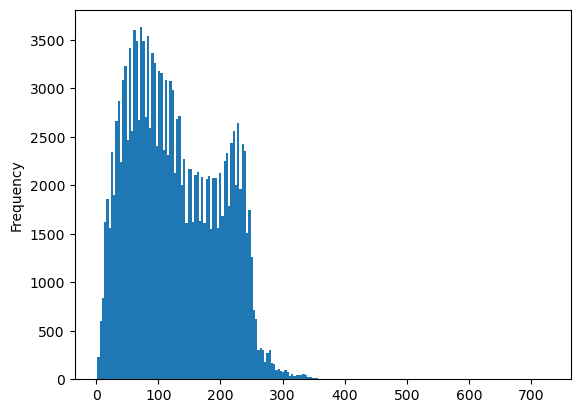

In [206]:
#Gráfico com tamanho das mensagens
df["Tamanho"].plot(bins=200, kind="hist")

In [207]:
#Descrição do tamanho
df.Tamanho.describe()

count    164170.000000
mean        127.174703
std          70.971855
min           2.000000
25%          68.000000
50%         117.000000
75%         187.000000
max         727.000000
Name: Tamanho, dtype: float64

array([<Axes: title={'center': 'Negativo'}>,
       <Axes: title={'center': 'Positivo'}>], dtype=object)

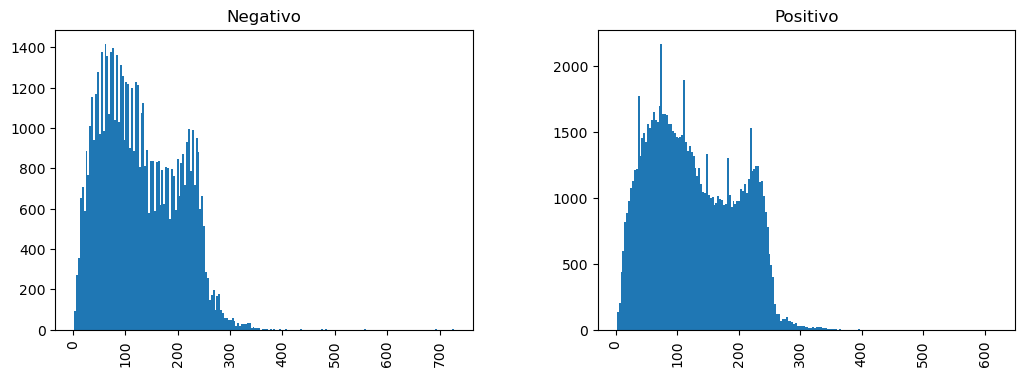

In [208]:
#Gráfico por classe
df.hist(column="Tamanho", by="Sentiment", bins=200, figsize=(12,4))

In [209]:
df.drop("Tamanho",axis=1,inplace=True)

<Axes: xlabel='Sentiment', ylabel='count'>

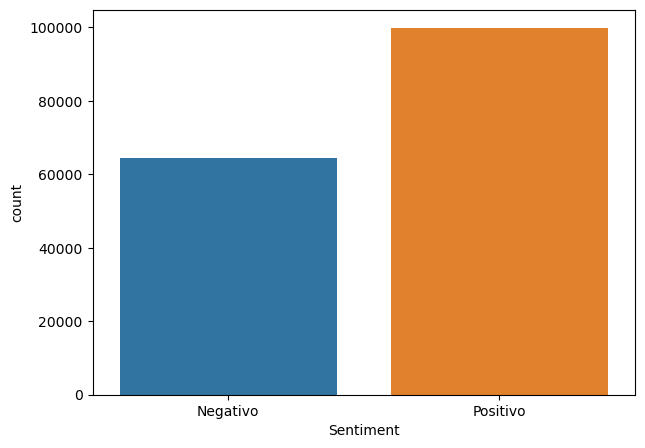

In [210]:
#Gráfico de contagem das classes
plt.figure(figsize=(7, 5))
sns.countplot(x=df.Sentiment)

In [211]:
#Processamento de texto
def text_process(mess):
  """
  Recebe uma sequência de texto e, em seguida, executa o seguinte:
  1. Remove toda a pontução
  2. Remove todas as stopwords
  3. Retorna uma lista do texto limpo
  """
  nopunc = [char for char in mess if char not in string.punctuation]
  nopunc = ''.join(nopunc)
  return [word for word in nopunc.split() if word.lower() not in stopwords.words("english")]

In [212]:
#Teste de Tokenização dos Tweets
df['Tweet'].head(5).apply(text_process)

0    [modi, promised, “minimum, government, maximum...
2    [say, vote, modi, welcome, bjp, told, rahul, m...
3    [asking, supporters, prefix, chowkidar, names,...
4    [answer, among, powerful, world, leader, today...
8    [upcoming, election, india, saga, going, impor...
Name: Tweet, dtype: object

In [213]:
# Criação de sub_df com categorias target equilibradas
sub_df_0 = df[df.Sentiment == "Negativo"].sample(df.Sentiment.value_counts()[1], random_state=42)
sub_df_0.value_counts()

sub_df_1 = df[df.Sentiment == "Positivo"].sample(df.Sentiment.value_counts()[1], random_state=42)
sub_df_1.value_counts()

sub_df = pd.concat([sub_df_0, sub_df_1], axis=0,
                   sort=False, ignore_index=True)
print(sub_df.Sentiment.value_counts())
sub_df = sub_df.sample(frac=1, random_state=42, ignore_index=True)
sub_df

Negativo    64386
Positivo    64386
Name: Sentiment, dtype: int64


,Tweet,Sentiment
0,you fool razack before modi became cases were ...,Negativo
1,true dravidian brahmin cant get membership ary...,Negativo
2,oh god.,Positivo
3,i've was playing red lipstick redemption stuff...,Positivo
4,jaitley modi\ngot professional subramania swam...,Positivo
...,...,...
128767,best indian country narendr modi,Positivo
128768,and how is my microsoft of word of wisdom all ...,Positivo
128769,it`s so sad http://bit.ly/b8jth i love kelly...,Negativo
128770,bjp failed ி்ாு you have time see our farmers ...,Negativo


## Vetorização

Agora, temos as mensagens como listas de tokens (também conhecidas como [lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) e precisamos converter cada uma dessas mensagens em um vetor com o qual os modelos de algoritmo do SciKit Learn possam trabalhar.

Faremos isso em três etapas usando o modelo bag-of-words:

1. Contando quantas vezes uma palavra ocorre em cada mensagem (conhecida como frequência de termo)

2. Pesar as contagens, para que os tokens frequentes tenham um peso menor (frequência inversa do documento)

3. Normalizar os vetores para comprimento unitário, para abstrair do comprimento do texto original (L2 norm)

Vamos começar o primeiro passo:

Cada vetor terá tantas dimensões quantas forem as palavras únicas no corpus SMS. Primeiro, usaremos o **CountVectorizer** do SciKit Learn. Este modelo converterá uma coleção de documentos de texto em uma matriz de contagem de tokens.

Podemos imaginar isso como uma matriz bidimensional. Onde a dimensão 1 é todo o vocabulário (1 linha por palavra) e a outra dimensão são os documentos reais, neste caso uma coluna por mensagem de texto.

Por exemplo:

<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>


Como há tantas mensagens, podemos esperar muitas contagens com zero para a presença de uma dada palavra em um determinado documento. Por causa disso, o SciKit Learn produzirá uma [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix).

Após a contagem, a ponderação e a normalização dos termos podem ser feitas com [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), utilizando scikit-learn `TfidfTransformer`.

### O que é TF-IDF?
TF-IDF significa *term frequency-inverse document frequency*, e o tf-idf weight é um peso frequentemente usado na recuperação de informações e mineração de texto. Esse peso é uma medida estatística usada para avaliar a importância de uma palavra para um documento em uma coleção ou corpus. A importância aumenta proporcionalmente ao número de vezes que uma palavra aparece no documento, mas é compensada pela frequência da palavra no corpus. Variações do esquema de ponderação tf-idf são frequentemente usadas pelos mecanismos de pesquisa como uma ferramenta central na pontuação e classificação da relevância de um documento dada a consulta do usuário.

Uma das funções de classificação mais simples é calculada somando o tf-idf para cada termo de consulta; muitas funções de classificação mais sofisticadas são variantes desse modelo simples.

Normalmente, o tf-idf weight é composto por dois termos: o primeiro calcula a normalized Term Frequency (TF), aka. o número de vezes que uma palavra aparece em um documento, dividido pelo número total de palavras naquele documento; o segundo termo é a Frequência Inversa de Documentos (IDF), calculada como o logaritmo do número de documentos no corpus dividido pelo número de documentos onde o termo específico aparece.

**TF: Term Frequency**, mede a frequência com que um termo ocorre em um documento. Como cada documento é diferente em tamanho, é possível que um termo apareça muito mais vezes em documentos longos do que em documentos mais curtos. Assim, a frequência do termo é frequentemente dividida pelo comprimento do documento (também conhecido como o número total de termos no documento) como forma de normalização:

*TF(t) = (Número de vezes que o termo t aparece em um documento) / (Número total de termos no documento).*

**IDF: Inverse Document Frequency**, mede a importância de um termo. Ao calcular TF, todos os termos são considerados igualmente importantes. No entanto, sabe-se que certos termos, como “é”, “de” e “isso”, podem aparecer muitas vezes, mas têm pouca importância. Assim, precisamos pesar os termos frequentes enquanto escalamos os raros, calculando o seguinte:

*IDF(t) = log(Número total de documentos / Número de documentos com termo t nele).*

Veja abaixo um exemplo simples.

**Exemplo:**

Considere um documento contendo 100 palavras em que a palavra gato aparece 3 vezes.

O termo frequência (ou seja, tf) para gato é então (3/100) = 0,03. Agora, suponha que temos 10 milhões de documentos e a palavra gato aparece em mil deles. Então, a frequência inversa do documento (ou seja, idf) é calculada como log(10.000.000 / 1.000) = 4. Assim, o peso Tf-idf é o produto dessas quantidades: 0,03 * 4 = 0,12.

## Divisão de Treino/Teste

In [214]:
msg_train, msg_test, label_train, label_test = train_test_split(df["Tweet"], df["Sentiment"], test_size=0.3, random_state=42)

In [215]:
print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

114919 49251 164170


## Criando um pipeline de dados

Vamos executar nosso modelo novamente e, em seguida, prever fora do conjunto de teste. Usaremos o SciKit Learn [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) para armazenar um pipeline de fluxo de trabalho. Isso nos permitirá configurar todas as transformações que faremos nos dados para uso futuro. Vamos ver um exemplo de como funciona:

In [216]:
pipeline = Pipeline([
    ("bow", CountVectorizer(analyzer=text_process)),
    ("tfidf", TfidfTransformer()),
    ("classifier", MultinomialNB())
])

In [217]:
pipeline.fit(msg_train, label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000001740A54B5B0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [218]:
predictions = pipeline.predict(msg_test)

#### Matriz de Confusão
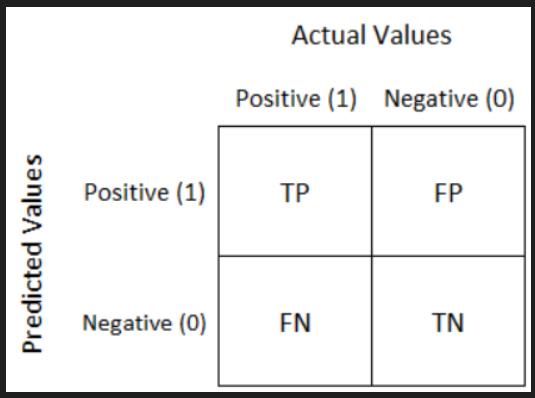

No campo do Aprendizado de Máquina uma matriz de confusão é uma tabela que permite a visualização do desempenho de um algoritmo de classificação. Essa tabela de contingência 2x2 especial é também chamada de matriz de erro.

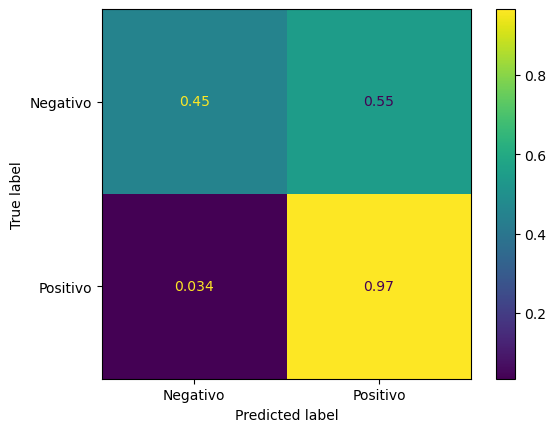

In [219]:
# plotar a confusion matriz
mc = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(label_test, predictions, normalize="true"), display_labels=pipeline.classes_)
mc.plot()
plt.show()

#### Classification Report
A __PRECISION__ é a razão TP / (TP + FP) onde TP é o número de verdadeiros positivos e FP o número de falsos positivos. A precision é intuitivamente a capacidade do classificador não rotular uma amostra negativa como positiva. De todos os valores preditos como positivos, a PRECISION define a proporção de valores realmente positivos acertados.

O __RECALL__ é a razão TP / (TP + FN) onde TP é o número de verdadeiros positivos e FN o número de falsos negativos. O RECALL é intuitivamente a habilidade do classificador em encontrar todas as amostras positivas. De todos os valores realmente positivos, o RECALL define a proporção de acertos.

A pontuação __F1-SCORE__ pode ser interpretada como uma média harmônica ponderada da PRECISION e RECALL, onde uma pontuação F1-SCORE atinge seu melhor valor em 1 e pior pontuação em 0.

O __SUPPORT__ é o número de ocorrências de cada classe em y_true.

As médias relatadas incluem __MACRO_AVERAGE__ (média da média não ponderada por rótulo), __WEIGHTED_AVERAGE__ (média da média ponderada de suporte por rótulo) e SAMPLE_AVERAGE (somente para classificação multi-rótulo). A MICRO_AVERAGE (média do total de verdadeiros positivos, falsos negativos e falsos positivos) só é mostrada para multi-rótulo ou multiclasse com um subconjunto de classes, porque de outra forma corresponde à precisão e seria a mesma para todas as métricas


In [220]:
print(classification_report(predictions, label_test))

              precision    recall  f1-score   support

    Negativo       0.45      0.90      0.60      9768
    Positivo       0.97      0.73      0.83     39483

    accuracy                           0.76     49251
   macro avg       0.71      0.81      0.72     49251
weighted avg       0.86      0.76      0.79     49251



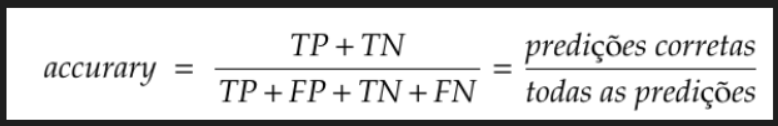